In [1]:
%matplotlib notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
from tqdm import tqdm
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
# Enable interactive plot
from matplotlib.animation import FuncAnimation
from scipy.sparse import diags
from scipy import stats, interpolate
import scipy.integrate as integrate

In [3]:
def brownian(n_brownians):
    """
    Returns several trajectories of a brownian motion as functions which can be evaluated on any point
    """
    Y = np.linspace(0, 1, 1000)
    
    n = len(Y) 
    sample_values = np.zeros((n, n_brownians))
    step = 1 / n
    
    for i in range(n - 1):
        sample_values[i + 1] = sample_values[i] + sqrt(step) * np.random.randn(n_brownians)
        
    f = interpolate.interp1d(Y[np.newaxis:],sample_values,kind='linear',axis=0)
    return f

In [4]:
def colored(vect):
    color = []
    for i in range(2**4+1):
        if vect[i] > 100:
            color += ['purple']
        elif vect[i] > 1:
            color += ['blue']
        else:
            color += ['cyan']
    return color  

In [5]:
from numpy.linalg import inv

def finite_differences_matrix(N):
    """
    Creates a finite-differences matrix for the 1D heat equation with
    Dirichlet boundary conditions.
        N : number of space points, int
        c : CFL condition, float
    Returns: N-2 x N-2 matrix    
    """
    # Number of unknowns (excluding boundary conditions)
    n = N - 2
    A = diags([np.ones(n)*(2),-np.ones(n-1) ,-np.ones(n-1)] , [0,1,-1])
    return -A

      

def init_cond(x):
    """
    Initial condition
        x : array
    Returns : len(x)-array    
    """
    #return 20*x*(1-x)*np.abs(x-0.5)*np.abs(np.sin(2*np.pi*x)) 
    return 10*np.abs(x-1)*np.abs(x-0.5)*np.abs( np.sin(2*np.pi*(x -x**3)) )


def drift(x,nature, scaling, dx, intensity):
    """
    Drift function
        x : array
        nature : string
        scaling : float
        dx : float
    Returns: len(x)-array    
    """
    m = dx**(-scaling)
    if nature=='dirac':
        return intensity*np.sqrt(m/(2*np.pi)) * np.exp(-(x-1)**2 * m /2) # - intensity*np.sqrt(m/(2*np.pi)) * np.exp(- (x-1)**2 * m /2)
    if nature == 'ind':
        return norm.cdf(x,0,1/m)
    if nature == 'bessel':
        return intensity/x**(0.5)
    return 0


def dW_func(Nx, MC):
    Nt = int((1/c)* (Nx**2))
    dt = 1/Nt
    return (c*dt)**(1/4)*np.random.normal(size=(Nx+1,Nt+1,MC))




def Spde(drift, nature, scaling, Nx, L, T, initial_cond , MC, noise, dW, intensity):
    """
    Computes a tamed Euler in time, finite-differences in space, scheme for the stochastic heat equation
        drift : func
        nature : string
        scaling : float
        Nx : number of space points, float
        CFL : float
        L : space limit, int
        T : time limit, int
        initial_cond : initial condition, func
        MC : Monte-Carlo, int
        noise : bool
    Returns : Nx x Nt x MC array if noise = True and Nx x Nt array if noise = False, where Nt is the number of time points.
    """
    Nx = dW.shape[0]-1
    Nt = int((1/c)* (Nx**2))
    Dt = dW.shape[1]-1
    MC = dW.shape[2]
    dt = 1/Nt
    dx = 1/Nx

    # Euler scheme
    x = np.linspace(0, 1, Nx+1)
    u0 = initial_cond #initial_cond doit etre un vecteur conforme à dW
    ue = np.zeros((Nx+1, Dt+1,MC))
    ue_imp = np.zeros((Nx+1, Dt+1,MC))
    if u0[0].shape == ():
        ue[:, 0,:] = u0[:,np.newaxis]
        ue_imp[:, 0,:] = u0[:,np.newaxis]
    else:
        ue[:, 0,:] = u0
        ue_imp[:, 0,:] = u0
        
    diff_matrix = finite_differences_matrix(Nx+1)
    N = Nx-1
    inv_diff = inv(np.diag(np.ones(N))-c*diff_matrix ) 
    for n in tqdm(range(0, Nt)):
        #for i in range(1, Nx):
        if noise == True:
            #W =  np.random.normal( scale= (c*dt)**(1/4), size=(Nx-1,MC) )
            ue[1:Nx, n+1,:] =  dt*drift(ue[1:Nx,n,:],nature, scaling, dx, intensity) \
                                    +ue[1:Nx, n,:]+  c *(diff_matrix* ue[1:Nx,n,:])\
                                                    + dW[1:Nx,n,:]
            ue_imp[1:Nx, n+1,:] =inv_diff*(  dt*drift(ue_imp[1:Nx,n,:],nature, scaling, dx, intensity) \
                                    +ue_imp[1:Nx, n,:] \
                                                    + dW[1:Nx,n,:] )
        else : 
            ue[1:Nx, n+1,0] =  dt*drift(ue[1:Nx,n,0],nature, scaling, dx, intensity) \
                                    +ue[1:Nx, n,0]+  c* (diff_matrix* ue[1:Nx,n,0]) 
                                                
    if noise == True:
        return ue, ue_imp
    else:
        return ue[:,:,0]




In [22]:
def Sheat_visual(T, L, Nx, reaction, nature, scaling, MC, Fps, visual, dW):
    """
    Plots a visual of the stochastic heat equation with a dirac drift
        T : time limit, int
        L : space limit, int
        Nx : number of space points
        reaction : drift function, func
        nature : string
        scaling : float
        MC : Monte-Carlo, int
        Fps : int
        visual : string, 'space' to visualise the evolution in space
    """
    dx = L/Nx  # spatial step size
    dt = c*(Nx)**(-2)  # time step size
    Nt = int(T/dt)  # number of time steps
    # Euler scheme
    x = np.linspace(0, L, Nx+1)
    u0 = init_cond(x)
    #xdirac= np.linspace(0,L,2**4+1)
    #maxdirac = drift(0,nature, scaling, dx)
    sample = int(np.random.rand()*MC)

    true_spde, true_spde_imp = Spde(drift, nature, scaling, Nx, L, T, u0, MC, True, dW, 100)
    #true_spde20 = Spde(drift, nature, scaling, Nx, L, T, u0 , MC, True, dW, 20)
    #true_spde50 = Spde(drift, nature, scaling, Nx, L, T, u0 , MC, True, dW, 50)
    #true_spde100 = Spde(drift, nature, scaling, Nx, L, T, u0 , MC, True, dW, 100)
    #true_spde1000 = Spde(drift, nature, scaling, Nx, L, T, u0 , MC, True, dW, 1000)
    #true_spde_0 = Spde(drift, 'None', scaling, Nx, L, T, u0 , MC, False, dW, 10)
    #timeaverage = np.mean(true_spde, axis=2)   
    #small_average = np.mean(true_spde[:,:,0:200], axis=2)
    #small_average1 = np.mean(true_spde[:,:,100:300], axis=2)
    #small_average2 = np.mean(true_spde[:,:,200:400], axis=2)
    #small_average3 = np.mean(true_spde[:,:,300:500], axis=2)
    small_average = np.mean(true_spde_imp[:,:,0:int(2*MC/8)], axis=2)
    small_average1 = np.mean(true_spde_imp[:,:,int(2*MC/8):int(4*MC/8)], axis=2)
    small_average2 = np.mean(true_spde_imp[:,:,int(4*MC/8):int(6*MC/8)], axis=2)
    small_average3 = np.mean(true_spde_imp[:,:,int(6*MC/8):MC], axis=2)
    #small_average4 = np.mean(true_spde[:,:,400:500], axis=2)
    #timeaverage100 = np.mean(true_spde100, axis=2) 
    #timeaverage1000 = np.mean(true_spde1000, axis=2)  
    
   
        
    u0 = init_cond(x)
    #u0dirac = -np.sin(np.pi*xdirac)
    #rscaled = (np.exp(drift(u0dirac,nature, scaling, dx)/maxdirac) -1)/(5*1e4)
    #print(rscaled)
    #color = colored(rscaled)
    
    fig, ax = plt.subplots()
    line_av_ = ax.plot(x, u0)  
    #line_av, = ax.plot(x, u0, label='t='+'{}'.format(0))  
    #line100, = ax.plot(x, u0, label='t='+'{}'.format(0))  
    #line1000, = ax.plot(x, u0, label='t='+'{}'.format(0))  
    y = -5*np.ones(len(x))
    #line2, = ax.plot(x,u0)
    #line3, =  ax.plot(x,u0) 
    #line4 = ax.scatter(xdirac,-np.ones(len(xdirac)), label='dirac force', marker="^", linestyle='None', s=rscaled) #s=rscaled,c=color
    ax.set_title('Evolution of the Stochastic heat equation with a dirac drift')
    ax.legend(loc='upper left', frameon=False)
    ax.set_xlabel('x')
    ax.set_xlim(0,1)
    ax.set_ylim(-5.1, 5.1)
    def animate(frame_num):
        #ax.cla()
        #ax.set_title('Stochastic heat equation with a dirac drift')
        #ax.legend(loc='upper left', frameon=False)
        ax.set_xlabel('x')
        ax.set_xlim(0, 1)
        ax.set_ylim(-5.1, 5.1)
        
        x = np.linspace(0, L, Nx+1)
        #y1 = timeaverage[:,frame_num]
        y_av = small_average[:,frame_num]
        y_av1= small_average1[:,frame_num]
        y_av2= small_average2[:,frame_num]
        y_av3= small_average3[:,frame_num]
        #y_av4= small_average4[:,frame_num]
        #y100 = timeaverage100[:,frame_num]
        #y1000 = timeaverage1000[:,frame_num]
        line_av, = ax.plot(x, y_av, facecolor='royalblue', alpha=0.8)
        line_av1, = ax.plot(x, y_av1, facecolor='royalblue', alpha=0.7)
        line_av2, = ax.plot(x, y_av2, facecolor='royalblue', alpha=0.6)
        line_av3, = ax.plot(x, y_av3, facecolor='royalblue', alpha=0.5)
        #line_av4, = ax.plot(x, y_av4, alpha=0.4)
        #line_av_ = ax.plot(x,y_av_, alpha=0.2) 
        #line_av.set_data((x, y_av))
        #line100.set_data((x, y100))
        #line1000.set_data((x, y1000))
        
        #line1.set_label('dirac')
        #line_av.set_label('Evolution of the stochastic heat equation with Dirac drift')
        #line_av.set_color('blue')
        #line100.set_label('100 x dirac')
        #line1000.set_label('1000 x dirac')
        #line.set_label('t='+'{}'.format('%.3f'%(dt*frame_num)))
        #line2.set_data((x, true_spde[:,frame_num, sample]))
        #line3.set_data((x, y))
        
        #ax.fill_between(x,y,y_av,facecolor='royalblue',alpha=0.8)
        #ax.fill_between(x,y,y_av1,facecolor='royalblue',alpha=0.7)
        #ax.fill_between(x,y,y_av2,facecolor='royalblue',alpha=0.6)
        #ax.fill_between(x,y,y_av3,facecolor='royalblue',alpha=0.5)
        #ax.fill_between(x,y,y_av4,facecolor='royalblue',alpha=0.4)
        #p = plt.fill_between(x,y_av,y,facecolor='dodgerblue',alpha=0.5)
        #line3.set_label('free heat')
        
        #xdirac= np.linspace(0,L,2**4+1)
        #line4.set_offsets(np.c_[xdirac, -np.ones(len(xdirac))])
        #rscaled = (np.exp(drift(true_spde[0:Nx+1:int(Nx/2**4),frame_num, sample],nature, scaling, dx)/maxdirac)-1)/(5*1e4)
        #color = colored(rscaled)
        #line4.set_sizes(sizes=rscaled)

        ax.legend(loc='upper left', frameon=False)
        

        return line_av, line_av1, line_av2, line_av3,
    
    

    anim = FuncAnimation(fig, animate, frames=range(Nt), interval=50, blit=True)
        
    plt.show()  
    anim.save(filename="Sheat_average_visual_time2.mp4", dpi=80, fps=Fps) 

In [23]:
#Example:
T=1
L=1
Nx = 2**5
MC = 10000 #1000
nature = 'dirac'
scaling = 0.5
Fps = 10
visual = 'time'
c = 0.4 #CFL

In [24]:
dW = 15*dW_func(Nx, MC)

100%|██████████| 2560/2560 [00:32<00:00, 78.02it/s]
No handles with labels found to put in legend.


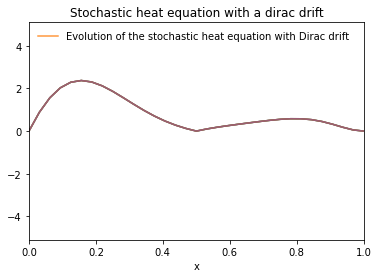

In [ ]:
Sheat_visual(T, L, Nx, drift, nature, scaling, MC, Fps, visual, dW)

In [ ]:
%%html
<video width="700" height="400" controls="controls">
    <source src="Sheat_average_visual_time2.mp4" type="video/mp4" />   
</video>